**This notebook gives a descripton of:**

1) Performing the sentiment analysis using the following techniques: *Logistic regression, Logistic regression with TFIDF vectorizer* and *Logistic regression with TFIDF vectorizer* and *n-grams techniques*.

2) **Analysing the accuracy** of the models and determining the best approach.

3) Identifying the **highest-used words** in each set of reviews, when grouped by rating.

In [4]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud
from fractions import Fraction
import re

# **Reading the data**

Now, we are reading the Merged.json file into dataframe and adding new columns to perform the efficiency of helpfulness metrics.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Read the file and add new columns helpfulnessnumerator and helpfulnessdenominator
file_path = '/content/drive/My Drive/Merged.json'
reviews = pd.read_json(file_path,lines=True)
reviews[['HelpfulnessNumerator','HelpfulnessDenominator']] = pd.DataFrame(reviews.helpful.values.tolist(), index = reviews.index)

# **Data preprocessing**

We remove the duplicates if any, based on the reviewerID, productID (asin) and unix timestamp. Adding the upvote metrics to analyze the dataset.

In [7]:
#Cleaning the data by eliminating duplicates
reviews.drop_duplicates(subset=['reviewerID', 'asin','unixReviewTime'],inplace=True)

#Adding the helpfulness and upvote percentages for metrics
reviews['Helpful %'] = np.where(reviews['HelpfulnessDenominator'] > 0, reviews['HelpfulnessNumerator'] / reviews['HelpfulnessDenominator'], -1)
reviews['% Upvote'] = pd.cut(reviews['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
reviews['Id'] = reviews.index;
reviews

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,HelpfulnessNumerator,HelpfulnessDenominator,Helpful %,% Upvote,Id
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,"[0, 0]",Spiritually and mentally inspiring! A book tha...,5,Wonderful!,1355616000,"12 16, 2012",0,0,-1.000000,Empty,0
1,A2S166WSCFIFP5,000100039X,"adead_poet@hotmail.com ""adead_poet@hotmail.com""","[0, 2]",This is one my must have books. It is a master...,5,close to god,1071100800,"12 11, 2003",0,2,0.000000,Empty,1
2,A1BM81XB4QHOA3,000100039X,"Ahoro Blethends ""Seriously""","[0, 0]",This book provides a reflection that you can a...,5,Must Read for Life Afficianados,1390003200,"01 18, 2014",0,0,-1.000000,Empty,2
3,A1MOSTXNIO5MPJ,000100039X,Alan Krug,"[0, 0]",I first read THE PROPHET in college back in th...,5,Timeless for every good and bad time in your l...,1317081600,"09 27, 2011",0,0,-1.000000,Empty,3
4,A2XQ5LZHTD4AFT,000100039X,Alaturka,"[7, 9]",A timeless classic. It is a very demanding an...,5,A Modern Rumi,1033948800,"10 7, 2002",7,9,0.777778,60-80%,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320452,A1YMNTFLNDYQ1F,B00LORXVUE,eyeused2loveher,"[0, 0]",Works great just like my original one. I reall...,5,This works just perfect!,1405900800,"07 21, 2014",0,0,-1.000000,Empty,320452
320453,A15TX8B2L8B20S,B00LORXVUE,Jon Davidson,"[0, 0]",Great product. Great packaging. High quality a...,5,Great replacement cable. Apple certified,1405900800,"07 21, 2014",0,0,-1.000000,Empty,320453
320454,A3JI7QRZO1QG8X,B00LORXVUE,Joyce M. Davidson,"[0, 0]","This is a great cable, just as good as the mor...",5,Real quality,1405900800,"07 21, 2014",0,0,-1.000000,Empty,320454
320455,A1NHB2VC68YQNM,B00LORXVUE,Nurse Farrugia,"[0, 0]",I really like it becasue it works well with my...,5,I really like it becasue it works well with my...,1405814400,"07 20, 2014",0,0,-1.000000,Empty,320455


<ipython-input-8-b1eb8b32aa44>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_s = reviews.groupby(['overall', '% Upvote']).agg({'Id': 'count'})


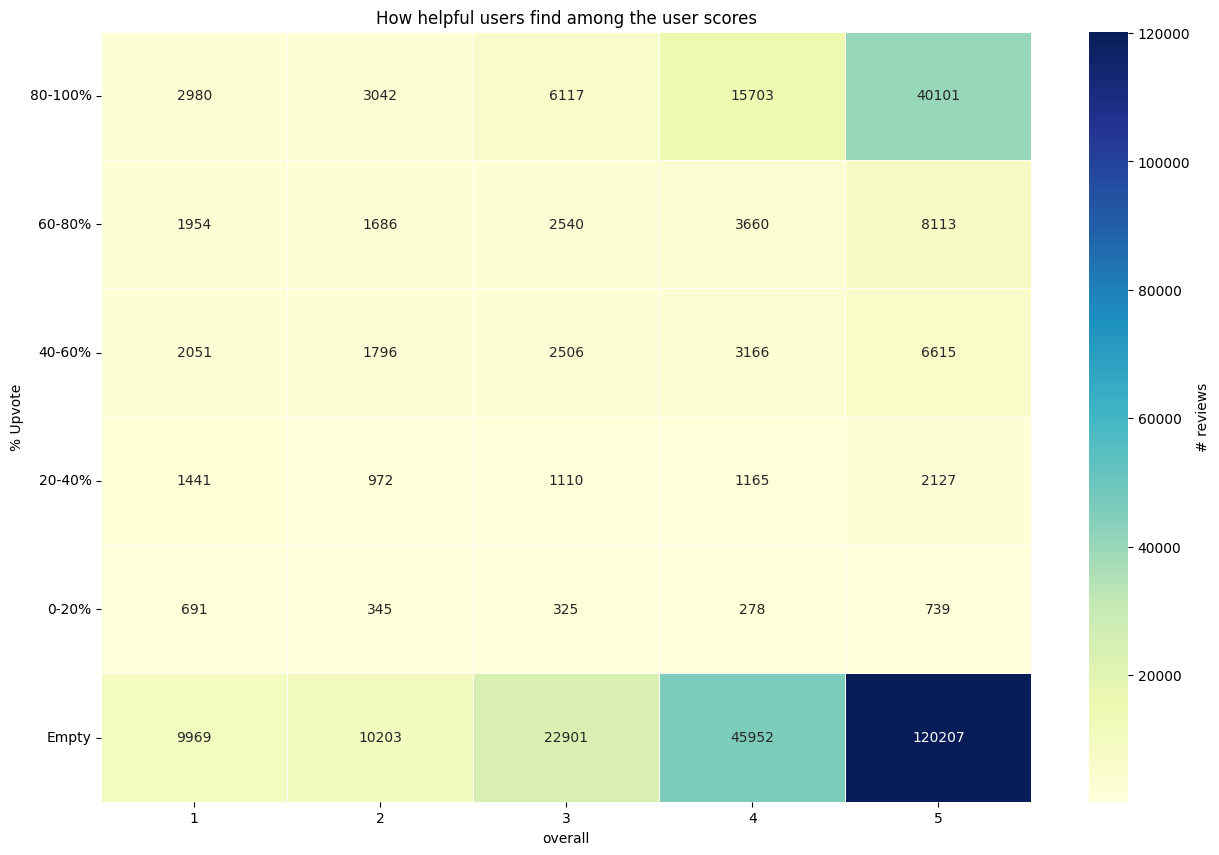

In [8]:
df_s = reviews.groupby(['overall', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among the user scores')
plt.show()

Removing the rating of 3, and convert the reviews into binary, 1- positive, 0- negative

In [9]:
df =  reviews[reviews['overall'] != 3]
X = df['reviewText']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['overall'].map(y_dict)

**Performing logistic regression on word count:**

In [10]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):

    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))

    if coef_show == 1:
        w = model.get_feature_names_out()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')
        print(coeff_df.tail(20).to_string(index=False))


text_fit(X, y, c, LogisticRegression())


# features: 177919
# train records: 213717
# test records: 71239


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.9208439197630511

-Top 20 positive-
        Word  Coefficient
 compliments     2.822738
  pleasantly     2.656638
   provoking     2.469804
      weaves     2.255487
    drawback     2.028365
    inherent     2.015175
  delightful     2.006556
reservations     2.004998
   interfere     1.979970
     easiest     1.958165
  refreshing     1.955226
       loves     1.951792
      turner     1.922767
    hesitate     1.903188
      classy     1.872455
      enjoys     1.868099
    blocking     1.867268
         gem     1.809576
  hesitation     1.795435
   jellybean     1.789341

-Top 20 negative-
          Word  Coefficient
      rambling    -2.298145
 dissappointed    -2.332945
         waste    -2.340770
disappointment    -2.349732
        poorly    -2.375659
  unacceptable    -2.382367
      plodding    -2.388137
        choppy    -2.398894
     returning    -2.433832
         chore    -2.540607
      unusable    -2.555039
      downhill    -2.574151
           dud   

**Baseline accuracy of the model is as follows:**

In [11]:
text_fit(X, y, c, DummyClassifier(),0)

# features: 177919
# train records: 213717
# test records: 71239
Model Accuracy: 0.8700711688822134


**TF-IDF vectorizer** is added to logistic regression to **improve the model accuracy**

In [12]:
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# features: 177919
# train records: 213717
# test records: 71239
Model Accuracy: 0.9245216805401536

-Top 20 positive-
       Word  Coefficient
      great    10.107843
       love     9.104876
  excellent     8.330706
     highly     7.852744
  perfectly     7.447538
    perfect     7.290599
    amazing     7.085413
  wonderful     6.268590
      loves     6.242739
       best     6.092368
    awesome     5.825240
      works     5.804732
       easy     5.738762
  complaint     5.657109
    enjoyed     5.633719
  fantastic     5.291714
compliments     5.041501
   favorite     4.938386
        job     4.889980
      worry     4.743862

-Top 20 negative-
          Word  Coefficient
      horrible    -5.344234
         worse    -5.385711
        refund    -5.461882
       garbage    -5.542185
        return    -5.548212
      terrible    -5.575016
         trash    -5.603130
 unfortunately    -5.867820
      returned    -6.168958
          poor    -6.179633
       stopped    -6.238139
 

**Accuracy** with tfidf has **increased from 87% to 92.5%.**
Logistic regression is now performed on TFIDF + n-grams.

In [13]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 6152085
# train records: 213717
# test records: 71239
Model Accuracy: 0.9199455354510871

-Top 20 positive-
            Word  Coefficient
           great    13.772757
            love    11.969939
       excellent    11.247945
         perfect    10.971178
       perfectly     9.697944
         amazing     9.488510
            best     9.195034
            easy     8.347948
       wonderful     8.297045
         awesome     8.289441
           loves     7.877418
           works     7.726433
         enjoyed     7.642553
          highly     7.639783
highly recommend     6.943471
            nice     6.942973
             job     6.655149
        favorite     6.654704
             bit     6.414783
           loved     6.399882

-Top 20 negative-
          Word  Coefficient
       garbage    -6.880982
          didn    -7.312709
        refund    -7.550689
         broke    -7.812204
       stopped    -8.062933
     returning    -8.304738
disappointment    -8.462121
      h

It can be observed that accuracy of LR has not changed much and stays at 92%.

## **Upvote prediction**

Analysing the pattern of downvotes by users to predict upvotes of the products

In [14]:
df = df[df['overall'] == 5]
df = df[df['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = df['reviewText']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = df['% Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts())

Class distribution:
% Upvote
1.0    48214
0.0     2866
Name: count, dtype: int64


It can be observed that the upvotes are skewed towards positive side. To avoid it, resampling the data has to be performed.

In [15]:
df_s = pd.DataFrame(data = [X,y]).T

Downvote_records = len(df_s[df_s['% Upvote'] == 0])
Downvote_indices = np.array(df_s[df_s['% Upvote'] == 0].index)

Upvote_indices = df_s[df_s['% Upvote'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df_s.loc[under_sample_indices, :]
X_u = under_sample_data['reviewText']
under_sample_data['% Upvote'] = under_sample_data['% Upvote'].astype(int)
y_u = under_sample_data['% Upvote']


print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 0])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  5732


Now, the similar operations as above are performed on the resampled data to measure accuracy of the model

In [16]:
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

# features: 33854
# train records: 4299
# test records: 1433
Model Accuracy: 0.6824842986741103

-Top 20 positive-
         Word  Coefficient
       needed     1.283600
       second     1.204762
         wwii     1.194666
  hillenbrand     1.178709
     protects     1.139128
        nancy     1.061479
illustrations     1.001205
    perfectly     0.993877
     engaging     0.950745
      lessons     0.946256
        works     0.941670
       picked     0.934041
   believable     0.932718
      cheaper     0.918071
    insurgent     0.907844
       mobile     0.907612
          lol     0.903740
        alien     0.872440
         mary     0.868392
        clear     0.861563

-Top 20 negative-
      Word  Coefficient
    source    -0.835237
  veronica    -0.848796
  hyperion    -0.862747
     thank    -0.876900
    sample    -0.877849
    purple    -0.888837
  enjoying    -0.890849
    george    -0.894850
     large    -0.898217
   hannity    -0.927783
      mars    -0.949041
conclusion 

68.25% is the accuracy of the model. Now, the same is performed with n-grams and tf-idf vectorizer

In [17]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

text_fit(X_u, y_u, tfidf_n, LogisticRegression())

# features: 361515
# train records: 4299
# test records: 1433
Model Accuracy: 0.7062107466852756

-Top 20 positive-
       Word  Coefficient
      phone     3.096206
       case     2.837620
     screen     2.210751
      works     1.789052
   children     1.756663
     iphone     1.693341
     charge     1.415151
        use     1.339522
        old     1.334532
       nice     1.330459
     stylus     1.307883
      cable     1.260709
    charger     1.247807
      cover     1.232673
  perfectly     1.229121
      price     1.196784
     highly     1.160536
works great     1.159611
  protector     1.151165
       ipad     1.127491

-Top 20 negative-
         Word  Coefficient
        thank    -1.037472
      history    -1.056859
veronica roth    -1.094040
         mars    -1.099139
    allegiant    -1.119693
      trilogy    -1.136586
      hannity    -1.157142
       george    -1.297388
          end    -1.312092
         read    -1.356837
     veronica    -1.394408
          sad   

The accuracy has now **improved to 70.62**

## Effect of non-contextual features

In [18]:
#pd.set_option('display.max_colwidth', -1)
print('Downvote score 5 comments examples:')
print(under_sample_data[under_sample_data['% Upvote']==0]['reviewText'].iloc[:100:20])
print('Upvote score 5 comments examples')
print(under_sample_data[under_sample_data['% Upvote']==1]['reviewText'].iloc[:100:20])

Downvote score 5 comments examples:
152     When i ordered this book i knew it was worth i...
1671    I loved this book.  It was sometimes hard to r...
3850    This is a spectacular book...humans settle mar...
4399    ... a bit slowly for my hunger of this story x...
4641    My only question is when is R.R. Martin going ...
Name: reviewText, dtype: object
Upvote score 5 comments examples
56831     This is a great resource for anyone who wants ...
57736     Are you a Lewis and Clark buff, just starting ...
71029     Much like some of Robert Kaplan's best writing...
149403    I got this item a month back and it works as e...
17545     Ella Enchanted by Gail Carson Levine has been ...
Name: reviewText, dtype: object


Above are the samples of the reviews that received downvotes and upvotes. The possible features have to be extracted from these reviews.

In [19]:
under_sample_data['word_count'] = under_sample_data['reviewText'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c == '!'))
under_sample_data['punctuation'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'reviewText'])]
y_num = under_sample_data['% Upvote']

% Upvote                   0           1
word_count        135.152477  182.813678
capital_count      24.525471   29.387648
question_mark       0.271458    0.214934
exclamation_mark    0.758548    0.693650
punctuation        22.615841   31.089672


# **Training the model to predict**
The model is now trained to predict upvotes

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0)

clf_lr = LogisticRegression().fit(X_train, y_train)
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

clf_svm = svm.SVC().fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))

Logistic Regression accuracy: 0.5617585484996511
SVM accuracy: 0.567341242149337


Accuracy is lower than the count feature and so, it can be determined that these non-contextual features are not the right choice to perform the prediction

# **Study of user behavior**
The user behavior has to be analyzed to improve the model performance and understand the underlying reasons for the bad or good reviews and improvise recommendation system. This also gives importance to word choices of a user when giving the reviews.



In [21]:
df_user = reviews.groupby(['reviewerID']).agg({'overall':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Rating count', 'Rating mean']
df_user = df_user.sort_values(by = 'Rating count', ascending = False)
print(df_user.head(10))

                Rating count  Rating mean
reviewerID                               
AFVQZQ8PW0L              426     4.598592
A2F6N60Z96CAJI           176     4.465909
A2NYK9KWFMJV4Y           152     4.907895
A2NOW4U7W3F7RI           141     4.773050
A22CW0ZHY3NJH8           141     4.482270
A1K1JW1C5CUSUZ           139     4.446043
A1EVV74UQYVKRY           138     4.731884
A1ODOGXEYECQQ8           134     4.313433
A23GFTVIETX7DS           127     4.362205
A36K2N527TXXJN           127     4.527559


Count of ratings is considered to select the user and user with the id A1EVV74UQYVKRY is randomly chosen

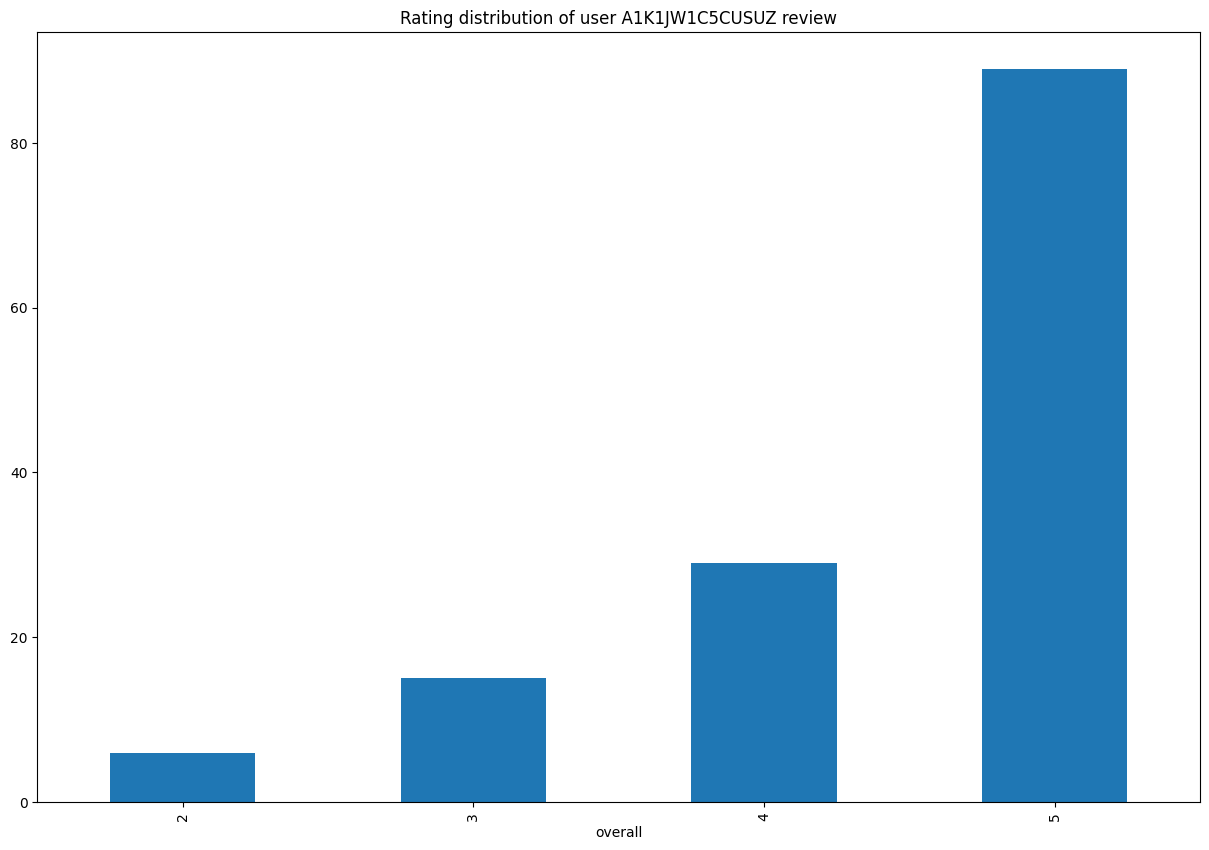

In [36]:
def plot_user(reviewerID):
    df_1user = reviews[reviews['reviewerID'] == reviewerID]['overall']
    df_1user_plot = df_1user.value_counts(sort=False).sort_index()
    ax = df_1user_plot.plot(kind = 'bar', figsize = (15,10), title = 'Rating distribution of user {} review'.format(reviews[reviews['reviewerID'] == reviewerID]['reviewerID'].iloc[0]))
    plt.show()

plot_user('A1K1JW1C5CUSUZ')

It can be observed that the user is happy with most of the products and hence, reviews are biased towards positive.

In [37]:
print(df_user[(df_user['Rating mean']<3.5) & (df_user['Rating mean']>2.5)].head())

                Rating count  Rating mean
reviewerID                               
A1X8VZWTOG8IS6            65     3.461538
A2EDZH51XHFA9B            40     3.450000
A3LDPF5FMB782Z            39     3.435897
A2F3SXHT6RBV81            32     3.031250
AU6DIIDZK2OQM             29     3.482759


Now, one of the users with mean rating near 3 (A1RRMZKOMZ2M7J) is chosen to perform the analysis

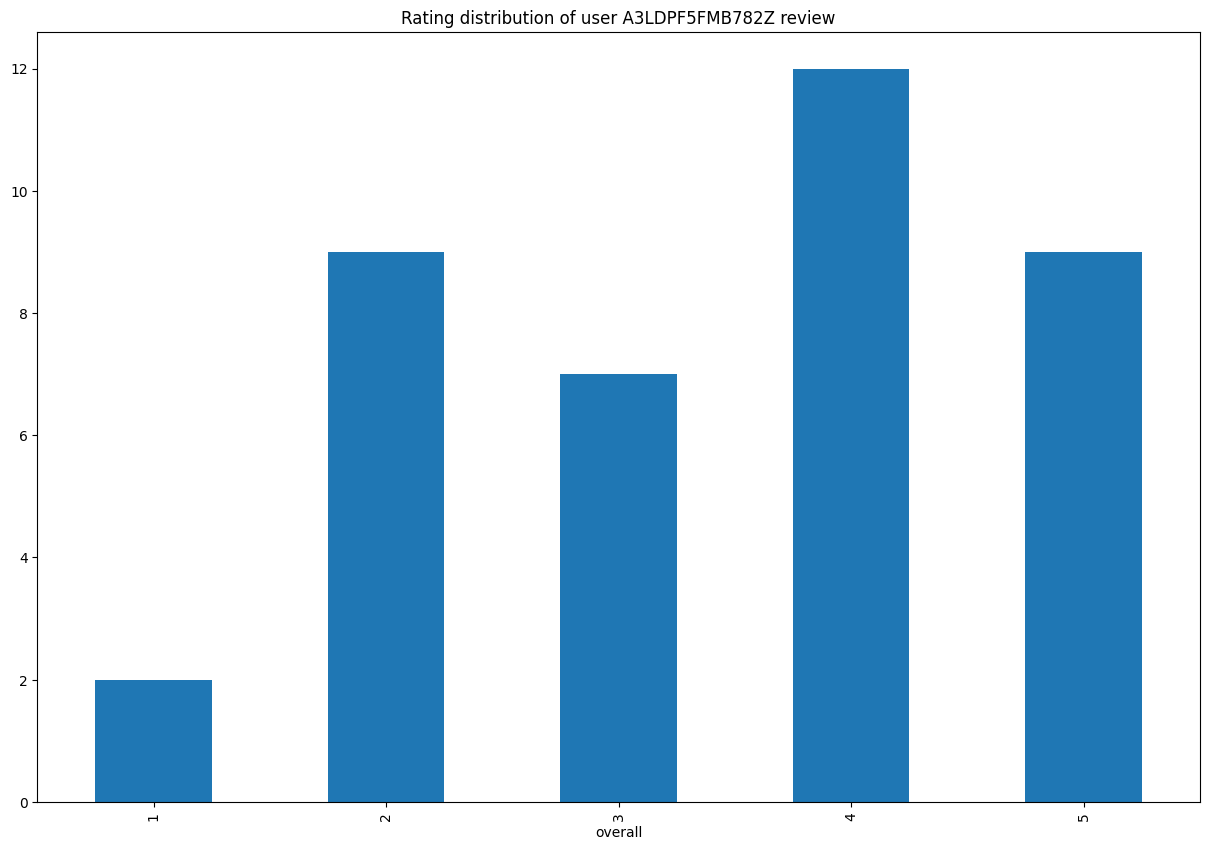

In [43]:
plot_user('A3LDPF5FMB782Z')

Most popular words used by the user for different ratings are observed. (2-grams and 3-grams are chosen for analysis)

In [57]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')

def get_token_ngram(score, benchmark, userid='all'):

    if userid != 'all':
        df = reviews[(reviews['reviewerID'] == userid) & (reviews['overall'] == score)]['reviewText']
    else:
        df = reviews[reviews['overall'] == score]['reviewText']

    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text]
    bigrams = ngrams(total_text,2)
    trigrams = ngrams(total_text, 3)

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)

    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A3LDPF5FMB782Z')
    print('score {j} reviews most popular 2-gram / 3-gram:')

    # Create DataFrame using list comprehension (faster and avoids append issues)
    test = pd.DataFrame([pd.Series(i, index=index) for i in d])

    print(test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


score {j} reviews most popular 2-gram / 3-gram:
                         Phrase  Count Occur %
0                 (high, speed)      2  100.0%
1            (high, speed, lte)      2  100.0%
2                  (speed, lte)      2  100.0%
3                 (2013, model)      1   50.0%
4      (efforts, screen, clear)      1   50.0%
..                          ...    ...     ...
113              (sticky, feel)      1   50.0%
114            (staff, install)      1   50.0%
115        (anyone, buy, boost)      1   50.0%
116  (speeds.as, october, 2013)      1   50.0%
117    (run, sprint/boost, new)      1   50.0%

[118 rows x 3 columns]
score {j} reviews most popular 2-gram / 3-gram:
                  Phrase  Count  Occur %
0      (wi-max, network)     13  144.44%
1         (lte, network)      7   77.78%
2   (hours, per, charge)      5   55.56%
3           (five, star)      5   55.56%
4           (hours, per)      5   55.56%
5          (per, charge)      5   55.56%
6        (boost, mobile)     

Now, the popular words for all users are observed

In [58]:
# score 1-5 reviews with all users
nltk.download('wordnet')
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test_list = []  # Create an empty list to store Series
    # easier benchmark since we have many different users here, thus different phrase
    d = get_token_ngram(j, 0.03)
    print('score {j} reviews most popular 2-gram / 3-gram:')
    for i in d:
        test_list.append(pd.Series(i, index=index))  # Append each Series to the list

    # Ensure 'test' is a DataFrame before sorting
    if isinstance(test, pd.Series):
        test = test.to_frame().T  # Convert Series to DataFrame

    test = test.sort_values('Count', ascending=False)
    print(test)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


score 1 reviews most popular 2-gram / 3-gram:
                     Phrase  Count Occur %
0         (charge, battery)      5  55.56%
1      (hours, per, charge)      4  44.44%
2         (properly, store)      4  44.44%
3           (phone, charge)      4  44.44%
4              (hours, per)      4  44.44%
5         (hours, internet)      4  44.44%
6             (per, charge)      4  44.44%
7   (provide, secure, grip)      3  33.33%
8          (drain, battery)      3  33.33%
9         (provide, secure)      3  33.33%
10           (outer, shell)      3  33.33%
11        (battery, charge)      3  33.33%
12           (eight, hours)      3  33.33%
13             (two, hours)      3  33.33%
14          (case, provide)      3  33.33%
15           (secure, grip)      3  33.33%
score 2 reviews most popular 2-gram / 3-gram:
                     Phrase  Count Occur %
0         (charge, battery)      5  55.56%
1      (hours, per, charge)      4  44.44%
2         (properly, store)      4  44.44%
3    

Now, only the adjectives are taken into consideration, as those express opinion and nouns don't.

In [59]:
def get_token_adj(score, benchmark, userid='all'):

    if userid != 'all':
        df = reviews[(reviews['reviewerID'] == userid) & (reviews['overall'] == score)]['reviewText']
    else:
        df = reviews[reviews['overall'] == score]['reviewText']

    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']

    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)

    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

In [65]:
# score 1-5 reviews with this user
nltk.download('averaged_perceptron_tagger_eng')
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A3LDPF5FMB782Z')
    print(f'score {j} reviews most popular adjectives word:')

    # Append data to the list
    for i in d:
        test_list.append(pd.Series(i, index=index))

    # Convert list to DataFrame only if it contains data
    if test_list:
        test = pd.DataFrame(test_list)
        test['Count'] = test['Count'].astype(int)  # Ensure sorting works correctly
        test = test.sort_values('Count', ascending=False)
        print(test)
    else:
        print("No data to display.")

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


score 1 reviews most popular adjectives word:
                  Phrase  Count  Occur %
0           (read, book)  10957    6.16%
1    (highly, recommend)   9462    5.32%
2    (screen, protector)   9128    5.13%
3          (work, great)   7221    4.06%
17                wi-max     17  188.89%
..                   ...    ...      ...
150               smooth      1    50.0%
151            speeds.as      1    50.0%
152                 good      1    50.0%
153                clear      1    50.0%
154             pre-zagg      1    50.0%

[155 rows x 3 columns]
score 2 reviews most popular adjectives word:
                  Phrase  Count  Occur %
0           (read, book)  10957    6.16%
1    (highly, recommend)   9462    5.32%
2    (screen, protector)   9128    5.13%
3          (work, great)   7221    4.06%
17                wi-max     17  188.89%
..                   ...    ...      ...
149              residue      1    50.0%
150               smooth      1    50.0%
151            speeds.a

Sentiment analysis is performed using logistic regression and support vector machines. The usage of non-contextual features in reviews is observed. Also, the user behavior is analyzed and the popular words used by the users are determined.

Rights: Vindhya V